#A Look Into Affordances of Citi and Capital Bikeshare Stations

##Part 1: What are Bikeshares? What are routes?

With the rise of traffic congestion in big cities and the need for more environmentally friendly solutions to travel, cities and businesses are looking to a common pastime to solve the need for alternative means to travel. In two large cities, New York City and Washington DC, have been met so positively that stationwise they have grown to become the two largest bikeshare programs in America. 

With the immense number of riders participating in the programs, different users will find different purposes for the system, whether they are tourists taking a bike out for a day as a convenient means of transportation between attractions or workers in New York City's financial district heading out from East Village in Manhattan in the morning for work. Given the locations of each station and their proximity to other locations in a city, people may use a station for different purposes. Let's begin by quantifying these "uses" in the form of bike trips. More specifically, we define a "trip" as one entry in our data having a "start" and "end" station.

We'll keep the libraries imported in a list here for convenience.

In [202]:
import glob
import csv
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import re

%matplotlib inline

In [163]:
def get_top_trips(path,N=10):
    
    #the headers on the CSV are slightly different depending on whether the data is from Citi or Capital
    if path=="capital":
        start_station = "Start station"
        end_station = "End station"
    if path=="citi":
        start_station = "start station name"
        end_station = "end station name"
        
    trips = []
    
    for filename in glob.glob('./'+path+'/*.csv'):  
        with open(filename,'rU') as f:
            reader = csv.DictReader(f)
            for row in reader:
                trips.append((row[start_station],row[end_station]))

    return Counter(trips).most_common(N)

In [164]:
get_top_trips("capital")

[(('Eastern Market Metro / Pennsylvania Ave & 7th St SE (31613)',
   'Lincoln Park / 13th & East Capitol St NE  (31619)'),
  4441),
 (('Calvert St & Woodley Pl NW (31106)',
   'Adams Mill & Columbia Rd NW (31104)'),
  4349),
 (('Adams Mill & Columbia Rd NW (31104)',
   'Calvert St & Woodley Pl NW (31106)'),
  4330),
 (('Lincoln Park / 13th & East Capitol St NE  (31619)',
   'Eastern Market Metro / Pennsylvania Ave & 7th St SE (31613)'),
  3462),
 (('USDA / 12th & Independence Ave SW (31217)',
   'USDA / 12th & Independence Ave SW (31217)'),
  3332),
 (('Massachusetts Ave & Dupont Circle NW (31200)', '15th & P St NW (31201)'),
  3238),
 (('16th & U St NW (31229)', 'Massachusetts Ave & Dupont Circle NW (31200)'),
  2992),
 (('15th & P St NW (31201)', 'Massachusetts Ave & Dupont Circle NW (31200)'),
  2838),
 (('Columbus Circle / Union Station (31623)', '13th & H St NE (31611)'), 2647),
 (('Massachusetts Ave & Dupont Circle NW (31200)',
   'Massachusetts Ave & Dupont Circle NW (31200)'),


In [165]:
get_top_trips("citi")

[(('Central Park S & 6 Ave', 'Central Park S & 6 Ave'), 11860),
 (('Broadway & W 60 St', 'Broadway & W 60 St'), 5710),
 (('Grand Army Plaza & Central Park S', 'Grand Army Plaza & Central Park S'),
  5428),
 (('E 43 St & Vanderbilt Ave', 'W 41 St & 8 Ave'), 3769),
 (('Grand Army Plaza & Central Park S', 'Broadway & W 60 St'), 3326),
 (('W 17 St & 8 Ave', '8 Ave & W 31 St'), 3244),
 (('Centre St & Chambers St', 'Centre St & Chambers St'), 3122),
 (('West St & Chambers St', 'West St & Chambers St'), 3121),
 (('W 21 St & 6 Ave', '9 Ave & W 22 St'), 3119),
 (('W 21 St & 6 Ave', 'W 22 St & 10 Ave'), 3023)]

In looking at the top 10 trips for each station, we see some very interesting results. For Capital bikeshare, the top most common trip and the 4th most common trip share the same stations. This could imply some sort of round trip behavior. For example, "Eastern Market Metro / Pennsylvania Ave & 7th St SE" is right beside a train station, which could indicate that many people are taking a bike from the train station to Capitol Hil for the day, and when it is time to go home, they take a bike back to the train station. For New York, the most frequent trip begins and ends at Central Park, which might indicate that people are taking the bike for a leisure drive and returning to the station after a stroll around the park. Furthermore, this may indicate that stations are being used for different purposes: some might be used to commute, as seen in the DC example, and others might be used for leisure, as seen in the NYC example.

But once again, we need to think computationally. Our data is limited in that we have no access to information about the individual people who ride the bikes, and we definitely can't interview people to figure out why people are riding bikes. What can we look at then? Patterns! 

##Part 2: A Look at Trip Duration as a Metric

We'll start by looking at the duration of the bike trips people take. What we're hoping to find from this is that people take different amounts of time biking if they use a station for a specific purpose. One way to reason through this is that people who take a bike to work do not want to come into work looking tired and sweaty. Additionally, due to work schedules, the time taken to go from one station to another would vary less due to the habitual commutes of workers. On the other hand, the amount of time taken to complete a round trip would vary greatly due to the less time-constrained nature of the trips.

In [166]:
def get_duration(path):
    #once again, the files are formatted slightly differently...
    if path=="citi":
        trip_duration = 'tripduration'
        start_station = 'start station id'
        end_station = 'end station id'
    if path=="capital":
        trip_duration = 'Duration'
        start_station = 'Start station ID'
        end_station = 'End station ID'
    duration = []
    for filename in glob.glob("./"+path+"/*.csv"):
        with open(filename,'rU') as f:
            reader = csv.DictReader(f)
            for row in reader:
                duration.append((row[trip_duration],row[start_station],row[end_station]))
    return duration

In [192]:
citibike = get_duration('citi')
print len(citibike)

capitalbike = get_duration('capital')
print len(capitalbike)

8081216
1240575


We'll define a round trip by looking at the start and end station to see if they are the same. One small issue, though--Capital bikeshare's data is formatted slightly differently, as shown below:

In [195]:
capital[1][0]

'0h 5min. 46sec.'

Since NYC's data comes in seconds, let's convert DC's data to seconds as well.

In [196]:
def parse_time(time):
    hms = re.sub("\s\s","",re.sub("[a-z]."," ",time)).split(" ")
    return int(hms[0])*60+60*int(hms[1])+int(hms[2])

In [197]:
nyc_round_trip = [int(entry[0]) for entry in citibike if entry[1]==entry[2]]
nyc_one_way = [int(entry[0]) for entry in citibike if entry[1]!=entry[2]]

dc_round_trip = [parse_time(entry[0]) for entry in capitalbike if entry[1]==entry[2]]
dc_one_way = [parse_time(entry[0]) for entry in capitalbike if entry[1]!=entry[2]]

In [198]:
min(nyc_round_trip), min(dc_round_trip)

(60, 0)

In [228]:
max(nyc_round_trip), max(dc_round_trip)

(571058, 10218)

Something isn't quite right. Looking at the data, the shortest time for NYC we're looking at is 60 seconds, and a staggering 0 seconds for DC. At a first glance, this is way too short for a "round trip". One possible explanation is that someone realized a bike they rented was malfunctioning and returned it immediately to the station. We'll need to filter out these low times before continuing so that our results aren't skewed. For now, let's say a round trip has to be at least five minutes to count. Likewise, for trip durations, both the Capital and Citi websites urge members to seek out a local bike rental shop if they need a bike for more than 24 hours. The longest trip for the NYC data is almost a week long, which will skew our results as well, so let's remove the long outliers too.

In [281]:
nyc_round_trip = [trip for trip in nyc_round_trip if trip>=300 and trip<20000]
dc_round_trip = [trip for trip in dc_round_trip if trip>=300 and trip<20000]

min(nyc_round_trip), min(dc_round_trip)

(300, 300)

Let's look at this visually:

In [287]:
def plot_freq(trip_data,city,nbins=500):

    plt.xlim([0, 15500])
    hist = plt.hist(trip_data,bins=np.arange(0,max(trip_data),len(trip_data)*1./nbins))
    plt.ylim([0,22500])
    plt.title(city + ' Round Trip Frequency')
    plt.xlabel('Trip Duration in Seconds')
    plt.ylabel('Counts')

    plt.show()

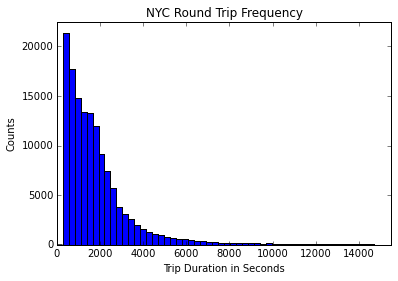

In [283]:
plot_freq(nyc_round_trip,"NYC",500)

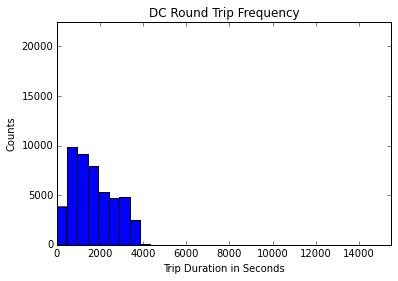

In [284]:
plot_freq(dc_round_trip,"DC",100)

Now that we have a better idea of how round trips work, let's take a look at one way trips. First things first, we need to check our data integrity and remove anything that doesn't make sense.

In [306]:
min(nyc_one_way),min(dc_one_way),max(nyc_one_way),max(dc_one_way)

(60, 27, 5416640, 57125)

Some of these numbers are unbelievable. In some other world, a 27 bike ride <i>might</i> be justifiable, but the max one way trip length for NYC is over 62 days, which is completely unreasonable. Let's filter those out.

In [307]:
nyc_one_way = [trip for trip in nyc_one_way if trip>=300 and trip<20000]
dc_one_way = [trip for trip in dc_one_way if trip>=300 and trip<20000]

min(nyc_one_way),min(dc_one_way),max(nyc_one_way),max(dc_one_way)

(300, 300, 19997, 18413)

In [337]:
def plot_freq_one_way(trip_data,city,nbins=500):
    
    plt.xlim([0, 15000])
    hist = plt.hist(trip_data,bins=np.arange(0,max(trip_data),len(trip_data)*1./nbins))
    plt.ylim([0,1600000])
    plt.title(city + ' One Way Trip Frequency')
    plt.xlabel('Trip Duration in Seconds')
    plt.ylabel('Counts')

    plt.show()

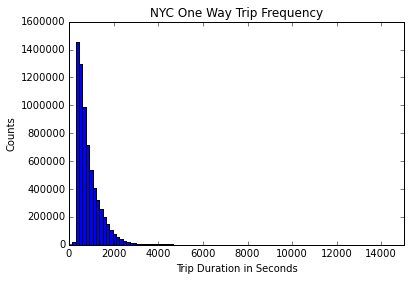

In [338]:
plot_freq_one_way(nyc_one_way,"NYC",45000)

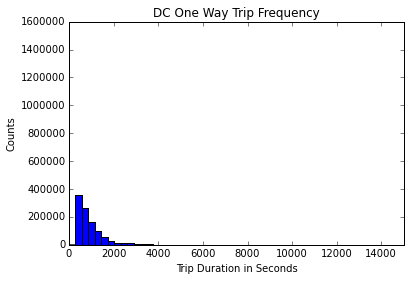

In [339]:
plot_freq_one_way(dc_one_way,"DC",3500)

Looking at the frequencies for each of the locations, there seems to be a general bin for trip duration that has the highest frequency across all the categories. Aside from that, it is difficult to say that frequency alone, if at all, can indicate whether a one way trip or a round trip occurs.

##Part 3: A Look at Usage Throughout the Day

Another idea is to look at how often people use bikes for various purposes throughout the day. One way of looking at this is that because people in the morning may use a bike to go to work, certain bike stations will be more likely to see activity in "bursts" at certain points throughout the day, whereas for people who exercise, those bursts may occur at a different time. To visualize this phenomenon, we'll turn to using heatmaps.

First things first, we need to reformat the data in a usable format. This means we need to start by segmenting our data by hours and day of the week.

In [409]:
from dateutil import parser

'''
set param='depart' or param='arrive'
'''
def count_trips(times,param,param2=None):
    trips = OrderedDict()
    for day in range(0,7):
        trips[str(day)] = OrderedDict()
        for hour in range(0,24):
            trips[str(day)][str(hour)] = 0

    counter = 0
    for time in times[param]:
        hour = parser.parse(time).strftime("%-H")
        day = parser.parse(time).strftime("%w")
        trips[day][hour] += 1
        counter += 1
#        if (counter % 20000 == 0):
#            print "Counted {0} trips".format(counter)
    
    if param2 is not None:
        for time in times[param2]:
            hour = parser.parse(time).strftime("%-H")
            day = parser.parse(time).strftime("%w")
            trips[day][hour] += 1
            counter += 1
#            if (counter % 20000 == 0):
#                print "Counted {0} trips".format(counter)
            
    return trips

To visualize the heatmap, we plan on using d3js, so we'll output the files to a .tsv format that our other code can read in.

In [355]:
def write_tsv(file_name, trips_dict):
    trips_array = list()
    for day in trips_dict:
        for hour in trips_dict[day]:
            trips_array.append({'day':day,'hour':hour,'count':trips_dict[day][hour]})

    with open(file_name, 'w') as f:
        dict_writer = csv.DictWriter(f, delimiter='\t',fieldnames=['day','hour','count'])
        dict_writer.writeheader()
        dict_writer.writerows(trips_array)
        


In [405]:
def get_one_way_dc():
    times = dict()
    times['depart'] = []
    times['arrive'] = []

    for filename in glob.glob("./capital/*.csv"):  
        with open(filename,'rU') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['Start station ID'] == row['End station ID']:
                    times['depart'].append(row['Start date'])
                    times['arrive'].append(row['End date'])
    return times

def get_one_way_nyc():
    times = dict()
    times['depart'] = []
    times['arrive'] = []

    for filename in glob.glob("./citi/*.csv"):  
        with open(filename,'rU') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['start station id'] != row['end station id']:
                    times['depart'].append(row['starttime'])
                    times['arrive'].append(row['stoptime'])
    return times

def get_round_trip_dc():
    times = dict()
    times['depart'] = []
    times['arrive'] = []

    for filename in glob.glob("./capital/*.csv"):  
        with open(filename,'rU') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['Start station ID'] != row['End station ID']:
                    times['depart'].append(row['Start date'])
                    times['arrive'].append(row['End date'])
    return times

def get_round_trip_nyc():
    times = dict()
    times['depart'] = []
    times['arrive'] = []

    for filename in glob.glob("./citi/*.csv"):  
        with open(filename,'rU') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['start station id'] == row['end station id']:
                    times['depart'].append(row['starttime'])
                    times['arrive'].append(row['stoptime'])
    return times

In [411]:
dc_one_way_data = get_one_way_dc()
dc_one_way_trips = count_trips(dc_one_way_data, 'arrive', 'depart');
write_tsv('./data/dc_one_way.tsv',dc_one_way_trips)

nyc_one_way_data = get_one_way_nyc()
nyc_one_way_trips = count_trips(nyc_one_way_data, 'arrive', 'depart');
write_tsv('./data/nyc_one_way.tsv',nyc_one_way_trips)

dc_round_trip_data = get_round_trip_dc()
dc_round_trips = count_trips(dc_round_trip_data, 'arrive', 'depart');
write_tsv('./data/dc_round_trips.tsv',dc_round_trips)

nyc_round_trip_data = get_round_trip_nyc()
nyc_round_trips = count_trips(nyc_round_trip_data, 'arrive','depart');
write_tsv('./data/nyc_round_trips.tsv',nyc_round_trips)

Thanks to the "%%javascript" magic word, we can embed JavaScript right into the cells! First thing we want to do is import d3js into the notebook.

In [418]:
%%javascript
require.config({
  paths: {
    d3: "http://d3js.org/d3.v3.min"
  }
});

require(["d3"], function(d3) {
  console.log(d3.version);
});

<IPython.core.display.Javascript object>

The "%%html" magic word allows us to style our HTML and SVG that we are about to create. Running this cell after the HTML and SVG is created will change the styling to match any changes made to the cell. It can also be run before running the HTML and SVG to predefine styles.

In [419]:
%%html
<style>
  rect.bordered {
    stroke: #E6E6E6;
    stroke-width:2px;   
  }
  text.mono {
    font-size: 9pt;
    font-family: Consolas, courier;
    fill: #aaa;
  }
  text.axis-workweek {
    fill: #000;
  }
  text.axis-worktime {
    fill: #000;
  }
  body {
    font-size: 9pt;
    font-family: Consolas, courier;
    fill: #aaa;
  }
</style>

With our styles in place, we have to define our div elements so that d3 can populate them. The code to do that is located below these images, as once again, running a cell in a notebook can apply changes retroactively. Unforutnately, due to security reasons, iPython does not allow arbitrary execution of JavaScript code unless it's on your own machine, so the code you see below must be run on your own machine to display the graphs inline. Images of the graphs are embedded after the code for viewing, though!

In [420]:
%%html

One-way trip in DC
<div id="dccommuter"></div>
Round trip in DC
<div id="dcleisure"></div>
One-way trip in NYC
<div id="nyccommuter"></div>
Round trip in NYC
<div id="nycleisure"></div>

In [421]:
%%javascript

//$(document).ready(function(){
draw_heatmap("./data/dc_round_trips.tsv", "#dccommuter");
draw_heatmap("./data/dc_one_way.tsv", "#dcleisure");
draw_heatmap("./data/nyc_one_way.tsv", "#nyccommuter");
draw_heatmap("./data/nyc_round_trips.tsv", "#nycleisure");
//});
var margin = { top: 50, right: 0, bottom: 100, left: 30 },
  width = 960 - margin.left - margin.right,
  height = 430 - margin.top - margin.bottom,
  gridSize = Math.floor(width / 24),
  legendElementWidth = gridSize*2,
  buckets = 9,
  colors = ["#ffffd9","#edf8b1","#c7e9b4","#7fcdbb","#41b6c4","#1d91c0","#225ea8","#253494","#081d58"], // alternatively colorbrewer.YlGnBu[9]
  // colors = ["#ffffd9","#edf8b1","#c7e9b4","#7fcdbb","#41b6c4","#1d91c0","#225ea8","#253494","#081d58"], // alternatively colorbrewer.YlGnBu[9]
  days = ["Su", "Mo", "Tu", "We", "Th", "Fr", "Sa"],
  times = ["1a", "2a", "3a", "4a", "5a", "6a", "7a", "8a", "9a", "10a", "11a", "12a", "1p", "2p", "3p", "4p", "5p", "6p", "7p", "8p", "9p", "10p", "11p", "12p"];
function draw_heatmap(source, div) {
    d3.tsv(source,
      function(d) {
        return {
          day: +d.day,
          hour: +d.hour,
          value: +d.count
        };
      },
      function(error, data) {
        var maxCount = d3.max(data, function (d) { return d.value; });
        var colorScale = d3.scale.quantile()
            .domain([0, buckets - 1, 100])
            .range(colors);
        var svg = d3.select(div).append("svg")
            .attr("width", width + margin.left + margin.right)
            .attr("height", height + margin.top + margin.bottom)
            .append("g")
            .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
        var dayLabels = svg.selectAll(".dayLabel")
            .data(days)
            .enter().append("text")
              .text(function (d) { return d; })
              .attr("x", 0)
              .attr("y", function (d, i) { return i * gridSize; })
              .style("text-anchor", "end")
              .attr("transform", "translate(-6," + gridSize / 1.5 + ")")
              .attr("class", function (d, i) { return ((i >= 1 && i <= 5) ? "dayLabel mono axis axis-workweek" : "dayLabel mono axis"); });
        var timeLabels = svg.selectAll(".timeLabel")
            .data(times)
            .enter().append("text")
              .text(function(d) { return d; })
              .attr("x", function(d, i) { return i * gridSize; })
              .attr("y", 0)
              .style("text-anchor", "middle")
              .attr("transform", "translate(" + gridSize / 2 + ", -6)")
              .attr("class", function(d, i) { return ((i >= 7 && i <= 16) ? "timeLabel mono axis axis-worktime" : "timeLabel mono axis"); });
        var heatMap = svg.selectAll(".hour")
            .data(data)
            .enter().append("rect")
            // .attr("x", function(d) { return (d.hour - 1) * gridSize; })
            // .attr("y", function(d) { return (d.day - 1) * gridSize; })
            .attr("x", function(d) { return (d.hour) * gridSize; })
            .attr("y", function(d) { return (d.day) * gridSize; })
            .attr("rx", 4)
            .attr("ry", 4)
            .attr("class", "hour bordered")
            .attr("width", gridSize)
            .attr("height", gridSize)
            .style("fill", colors[0]);
        heatMap.transition().duration(1000)
            .style("fill", function(d) { return colorScale(d.value * 100 / maxCount); });
        heatMap.append("title").text(function(d) { return Math.round(d.value * 100 / maxCount) + " %"; });

        var legend = svg.selectAll(".legend")
            .data([0].concat(colorScale.quantiles()), function(d) { return d; })
            .enter().append("g")
            .attr("class", "legend");
        legend.append("rect")
          .attr("x", function(d, i) { return legendElementWidth * i; })
          .attr("y", height)
          .attr("width", legendElementWidth)
          .attr("height", gridSize / 2)
          .style("fill", function(d, i) { return colors[i]; });
        legend.append("text")
          .attr("class", "mono")
          .text(function(d) { return "≥ " + (Math.round(d)) + " %"; })
          .attr("x", function(d, i) { return legendElementWidth * i; })
          .attr("y", height + gridSize);
        svg.append("text")
          .text("percentage of riders")
          .attr("x", function(d) { return legendElementWidth * 9; })
          .attr("y", height + gridSize)
    });
}

<IPython.core.display.Javascript object>

With the code aside, let's focus on the heatmaps themselves. A couple things stand out. First of all, the darkest regions for the one-way trips are at exactly 9am and from 6-7pm. This happens to overlap with the rush-hour times, indicating that the majority of one-way trips in both DC and NYC are for the purpose of commuting on weekdays. On weekends, most trips occur in the afternoon and early evening. For the round trips, there are no real patterns discernable for the weekdays, although on the weekends, there is a very high frequency of riders, which might indicate that those riders choose to ride bikes for leisurely purposes.

<img src='https://raw.githubusercontent.com/girikuncoro/bikeshare/master/viz/one_way_dc.png'/>

<img src='https://raw.githubusercontent.com/girikuncoro/bikeshare/master/viz/round_trip_dc.png'/>

<img src='https://raw.githubusercontent.com/girikuncoro/bikeshare/master/viz/one_way_nyc.png'/>

<img src='https://raw.githubusercontent.com/girikuncoro/bikeshare/master/viz/round_trip_nyc.png'/>